In [930]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision.ops.stochastic_depth import StochasticDepth
import torch.nn.functional as F
from typing import Tuple, List
from collections import OrderedDict
from math import ceil
import numpy as np
import matplotlib.pyplot as plt


## Construct Standard Self-Attention and Relative Position Self-Attention Blocks
* MaxViT creates $P$ x $P$ square patches along the spatial dim
    * $B$: batch size
    * $T$: number of tokens being attended to.
        * For MaxViT's Block Attention, $P_h=P_w=P \ \ \ \ \ \rightarrow$ $ \ \  T = P$ x $P$
        * For MaxViT's Grid Attention,  $P_h=\frac{H}{P}$, $P_w=\frac{W}{P} \rightarrow$  $T = \frac{H}{P}$ x $\frac{W}{P}$
    * $C$: channel size (embedding dimension input to Self-Attention)
    * $HS$: head size (embedding dimension returned by Self-Attention) 


In [836]:
# Standard Self-Attention Head
class StdSAHead(nn.Module):  
    def __init__(self, embd_size, head_size, dropout):
        super().__init__()
        self.key = nn.Linear(embd_size, head_size)
        self.query = nn.Linear(embd_size, head_size)
        self.value = nn.Linear(embd_size, head_size)
        self.scale = head_size**(-0.5)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        k = self.key(x)   # (B,T,C) --> (B,T,HS)
        q = self.query(x) # (B,T,C) --> (B,T,HS)
        v = self.value(x) # (B,T,C) --> (B,T,HS)
        
        # dot product between query and all keys, scale by 1/sqrt(head_size) for scaled SA
        wei = (q @ k.transpose(-2,-1)) * self.scale # (B,T,HS)@(B,HS,T) --> (B,T,T)
        wei = F.softmax(wei, dim=-1)  # (B,T,T)
        wei = self.dropout(wei)
        
        # weighted "average" of the value
        out = wei @ v      # (B,T,T) @ (B,T,HS) -> (B,T,HS)
        return out        

In [837]:
# Standard Multi-Head Self-Attention Heads
class StdMultiHeadSA(nn.Module):
    def __init__(self, embd_size, head_size, dropout):
        super().__init__()
        self.num_heads = embd_size // head_size
        self.heads = nn.ModuleList([StdSAHead(embd_size, head_size, dropout) for _ in range(self.num_heads)])
        self.proj = nn.Linear(self.num_heads*head_size, embd_size)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        parallel_heads = [h(x) for h in self.heads]     # (B,T,C) --> [(B,T,HS)] * num_heads
        merge_heads = torch.cat(parallel_heads, dim=-1) # [(B,T,HS)] * num_heads --> (B,T,HS*num_heads) 
        proj = self.proj(merge_heads)                   # (B,T,HS*num_heads) --> (B,T,C)
        proj = self.dropout(proj)
        return proj

#### Indexing into a Relative Position Embedding Table

Given a $(h,w)$ matrix, for any two positions $(i_1, j_1)$ and $(i_2 , j_2)$ in the matrix, a vector can express the difference between 2 points given by:  $\langle x, y \rangle= \langle i_2-i_1, j_2-j_1\rangle$

Observe that $x \in [-(h-1), (h-1)]$, such that $x$ can take on $2h-1$ different values.
Observe that $y \in [-(w-1), (w-1)]$, such that $x$ can take on $2w-1$ different values.

Therefore, there exist a total of $(2h-1)(2w-1)$ unique vectors possible to move from an arbitrary $(i_1, j_1)$ and $(i_2 , j_2)$ in the matrix.

In order to give each of these relative position a unique non-negative index (such that they can index into nn.Parameter), we perform the following operation for any $\langle x, y\rangle$:
* $index(x,y) = (x + (h-1)) * (2w - 1) + (y + (w-1))$
    * we shift $x$ by $(h-1)$ to be all positive s.t. $[-(h-1),(h-1)] \ \  \mapsto [0, 2(h-1)]$
    * we shift $y$ by $(w-1)$ to be all positive s.t. $[-(w-1),(w-1)] \ \ \mapsto [0, 2(w-1)]$
    * we scale $x$ such that we are able to use the sum of the $x$ component of a vector and $y$ component of a vector without having redundancy
        * ie with no scaling $\langle0, 1\rangle$ and $\langle1, 0\rangle$ map to index 1, but with scaling $\langle0,1\rangle$ maps to $1$ and $\langle1,0\rangle$ maps to $(2w - 1)$ (and there is no redundancy since the maximal y-vector $\langle0, 2(w-1)\rangle$ maps to $2w-2$ )


In [838]:
height, width = 5,5
coords = torch.stack(torch.meshgrid([torch.arange(height), torch.arange(width)], indexing='ij'))
coords_flat = torch.flatten(coords, 1)
relative_coords = coords_flat[:, :, None] - coords_flat[:, None, :]  
x_coords = relative_coords[0] 
y_coords = relative_coords[1] 

print("for a 5x5 grid where every point is assigned an index (left to right row-wise):")
i = 4
j = 0
print(f"Unscaled vector between point {i} and point {j}: <{x_coords[i][j].item()}, {y_coords[i][j].item()}>")

i = 5
j = 0
print(f"Unscaled vector between point {i} and point {j}: <{x_coords[i][j].item()}, {y_coords[i][j].item()}>")

for a 5x5 grid where every point is assigned an index (left to right row-wise):
Unscaled vector between point 4 and point 0: <0, 4>
Unscaled vector between point 5 and point 0: <1, 0>


In [839]:
def relative_position_index(height: int, width: int) -> torch.Tensor:    
    coords = torch.stack(torch.meshgrid([torch.arange(height), torch.arange(width)], indexing='ij'))
    coords_flat = torch.flatten(coords, 1)
    
    # create a grid of (h, w, 2), where relative_coords[i][j] is <x,y> vector to go from i to j
    relative_coords = coords_flat[:, :, None] - coords_flat[:, None, :]

    # scale and sum to create unique nonzero indices for every vector
    x_coords = relative_coords[0]   + (height-1)  # (h,w), shift to all pos from [-(h-1),(h-1)] --> [0, 2(h-1)]
    y_coords = relative_coords[1]   + (width-1)   # (h,w), shift to all pos from [-(w-1),(w-1)] --> [0, 2(w-1)] 
    return x_coords * (2*width - 1) + y_coords    # (h,w), scale x_coords to ensure every unique <x,y> has unique index

In [840]:
# Relative Position Embedding Self-Attention Head
class RelPosSAHead(nn.Module):
    def __init__(self, embd_size, head_size, patch_h, patch_w, dropout):
        super().__init__()
        self.key = nn.Linear(embd_size, head_size)
        self.query = nn.Linear(embd_size, head_size)
        self.value = nn.Linear(embd_size, head_size)
        self.scale = head_size**(-0.5)
        self.dropout = nn.Dropout(dropout)
        
        # PxP square patches
        self.patch_h = patch_h  # == P_h
        self.patch_w = patch_w  # == P_w
        self.num_patch_elem = patch_h*patch_w  # == T
        # buffer generated indices for every unique vector from i-->j for any i,j \in [0,T]
        #    and flatten to 1D so same shape as self.pos_emb
        self.register_buffer("rel_pos_idx", relative_position_index(patch_h, patch_w).view(-1))  # (T**2)
        # gen embedding table for total num of unique indices in self.rel_pos_idx
        self.pos_emb = nn.Embedding((2*patch_h-1)*(2*patch_w-1), 1)   # ((2h-1)(2w-1),1)

    def forward(self, x):
        k = self.key(x)   # (B,T,C) --> (B,T,HS)
        q = self.query(x) # (B,T,C) --> (B,T,HS)
        v = self.value(x) # (B,T,C) --> (B,T,HS)
        
        # dot product between query and all keys, scale by 1/sqrt(head_size) for scaled SA
        wei = (q @ k.transpose(-2,-1)) * self.scale # (B,T,HS)@(B,HS,T) --> (B,T,T)

        # add relative pos embedding
        rel_pos_emb = self.pos_emb(self.rel_pos_idx) # (T**2, 1)
        rel_pos_emb = rel_pos_emb.view(1, self.num_patch_elem, self.num_patch_elem) # (1, T, T)
        wei = wei + rel_pos_emb   # (B,T,T)+(1,T,T) --> (B,T,T)
        
        wei = F.softmax(wei, dim=-1)  # (B,T,T)
        wei = self.dropout(wei)
        
        # weighted "average" of the value
        out = wei @ v      # (B,T,T) @ (B,T,HS) -> (B,T,HS)
        return out        

In [842]:
# Relative Position Embedding Multi-Head Self-Attention Heads
class RelPosMultiHeadSA(nn.Module):
    def __init__(self, embd_size, head_size, patch_h, patch_w, dropout):
        super().__init__()
        self.num_heads = embd_size // head_size
        self.heads = nn.ModuleList([RelPosSAHead(embd_size, head_size, patch_h, patch_w, dropout) for _ in range(self.num_heads)])
        self.proj = nn.Linear(self.num_heads*head_size, embd_size)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        parallel_heads = [h(x) for h in self.heads]     # (B,T,C) --> [(B,T,HS)] * num_heads
        merge_heads = torch.cat(parallel_heads, dim=-1) # [(B,T,HS)] * num_heads --> (B,T,HS*num_heads) 
        proj = self.proj(merge_heads)                   # (B,T,HS*num_heads) --> (B,T,C)
        proj = self.dropout(proj)
        return proj

## Construct Standard Transformer and Relative Positional Transformer Blocks


In [843]:
# Feed Forward Network
class FFN(nn.Module):
    def __init__(self, embd_size, dropout):
        super().__init__()
        self.ffn = nn.Sequential(
            nn.Linear(embd_size, embd_size*4),
            nn.GELU(),
            nn.Linear(embd_size*4, embd_size),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        x = self.ffn(x)  # (B,T,C) --> (B,T,C*4) --> (B,T,C)
        return x    

In [844]:
# Standard Transformer Block
class StdTBlock(nn.Module):
    def __init__(self, embd_size, head_size, dropout):
        super().__init__()
        self.SA = StdMultiHeadSA(embd_size, head_size, dropout)
        self.FFN = FFN(embd_size, dropout)
        self.ln1 = nn.LayerNorm(embd_size)
        self.ln2 = nn.LayerNorm(embd_size)
        
    def forward(self, x):
        x = self.SA(self.ln1(x)) + x  # (B,T,C) --> (B,T,C)
        x = self.FFN(self.ln2(x)) + x # (B,T,C) --> (B,T,C)
        return x

In [645]:
# Relative Position Embedding Transformer Block
class RelPosTBlock(nn.Module):
    def __init__(self, embd_size, head_size, patch_h, patch_w, dropout):
        super().__init__()
        self.SA = RelPosMultiHeadSA(embd_size, head_size, patch_h, patch_w, dropout)
        self.FFN = FFN(embd_size, dropout)
        self.ln1 = nn.LayerNorm(embd_size)
        self.ln2 = nn.LayerNorm(embd_size)
        
    def forward(self, x):
        x = self.SA(self.ln1(x)) + x  # (B,T,C) --> (B,T,C)
        x = self.FFN(self.ln2(x)) + x # (B,T,C) --> (B,T,C)
        return x

## Explore Grid Partitioning 
<div>
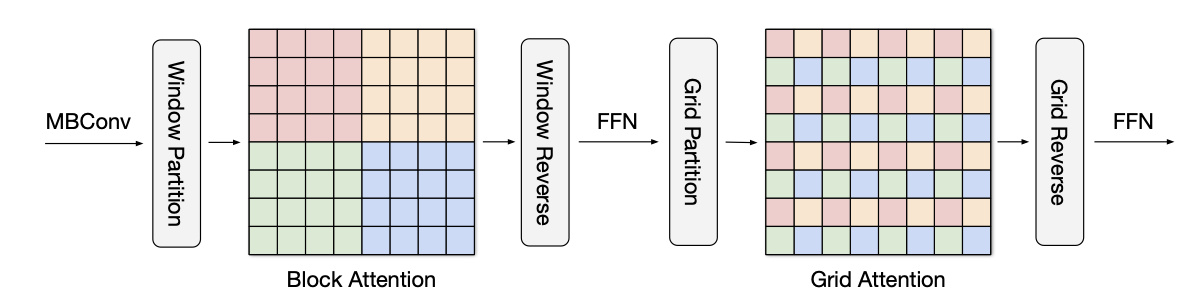
</div>
<div>
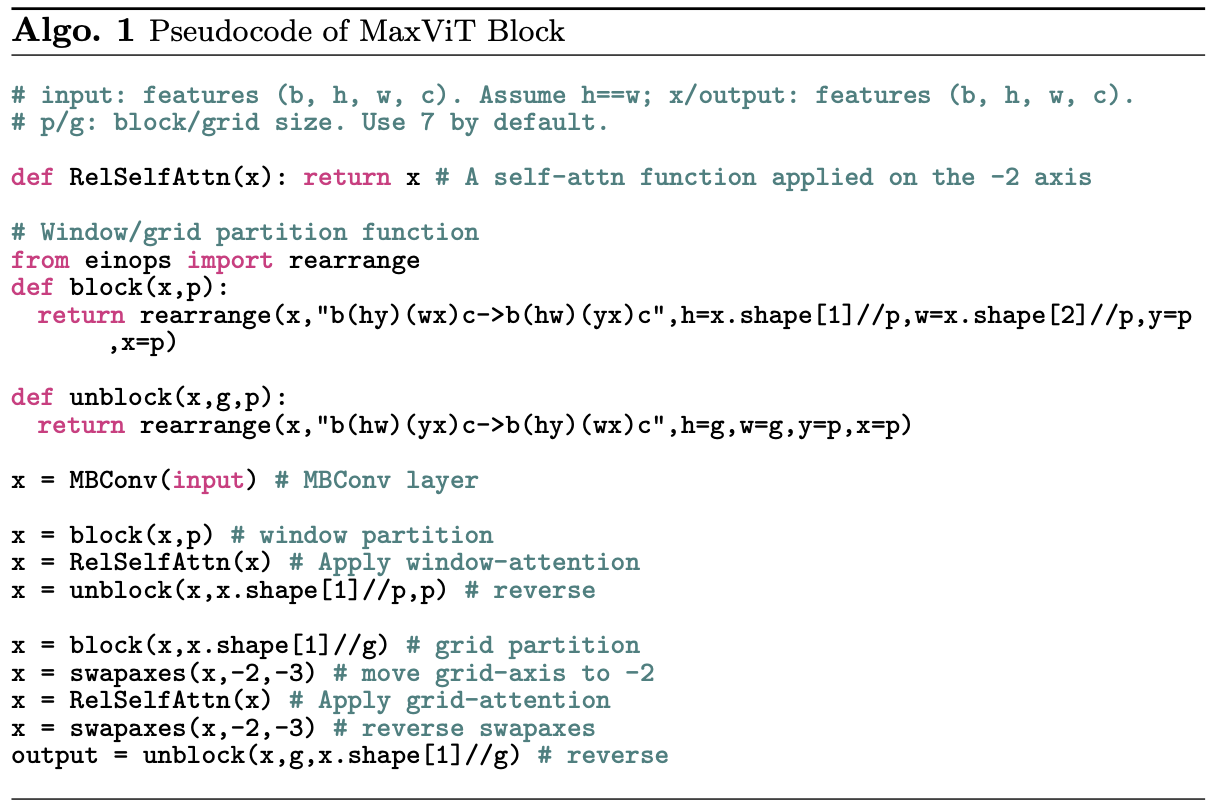
</div>

* from MaxViT (Z. Tu et al.)
    * **Block Attention** (axis 0): apply SA within non-overlapping patches
        * each pixel in a patch attends to every other pixel in a patch (*local understanding*)
        * across batch dim of total number of patches (as well as original batch of unpartitioned images)
    * **Grid Attention** (axis 1): apply SA across non-overlapping patches
        * each pixel in a patch attends to every other pixel in same location in different patch (*global understanding*)
        * across batch dim of total number of pixels per patch (as well as original batch of unpartitioned images)



torch.Size([8, 8, 3])


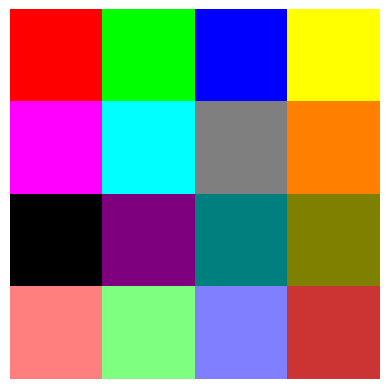

In [646]:
# Initialize an 8x8 tensor with 3 channels for RGB to test gridding, courtesy of chatGPT
test_image = torch.zeros(8, 8, 3)

# Define a list of 16 colors (RGB format, values between 0 and 1) for 2x2 patches
colors = [
    [1.0, 0.0, 0.0],  # Red
    [0.0, 1.0, 0.0],  # Green
    [0.0, 0.0, 1.0],  # Blue
    [1.0, 1.0, 0.0],  # Yellow
    [1.0, 0.0, 1.0],  # Magenta
    [0.0, 1.0, 1.0],  # Cyan
    [0.5, 0.5, 0.5],  # Gray
    [1.0, 0.5, 0.0],  # Orange
    [0.0, 0.0, 0.0],  # Black
    [0.5, 0.0, 0.5],  # Purple
    [0.0, 0.5, 0.5],  # Teal
    [0.5, 0.5, 0.0],  # Olive
    [1.0, 0.5, 0.5],  # Light Red
    [0.5, 1.0, 0.5],  # Light Green
    [0.5, 0.5, 1.0],  # Light Blue
    [0.8, 0.2, 0.2],  # Crimson
]

# Fill each 2x2 patch with a different color
for i in range(4):
    for j in range(4):
        test_image[i*2:(i+1)*2, j*2:(j+1)*2, :] = torch.tensor(colors[i*4+j])

print(test_image.shape)
# Visualize the image using Matplotlib
plt.imshow(test_image.numpy())
plt.axis('off')  # Hide the axes for a cleaner look
plt.show()

torch.Size([16, 2, 2, 3])


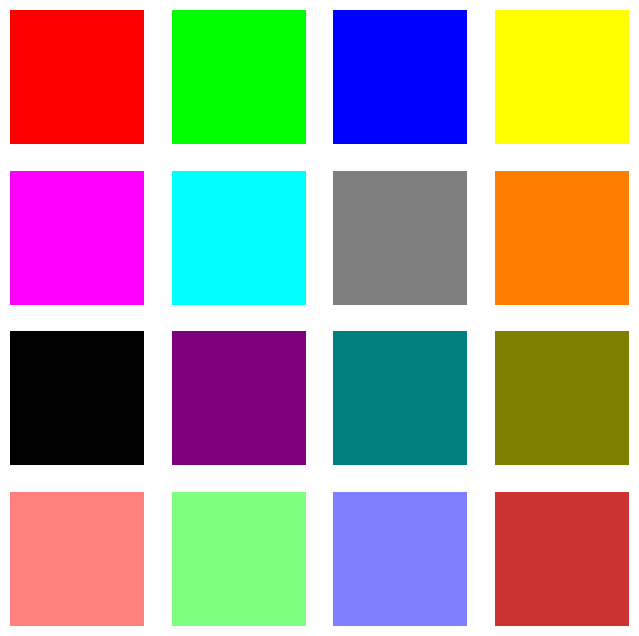

In [647]:
# "BLOCK Partition" test!
P = 2   # based on pseudo-code from paper, we should have 16 different 2x2 "windows" given our 8x8 RGB image

# reformat to image from (H,W,C) to shape PyTorch module will expect (C,H,W)
x = test_image.permute(2,0,1)
x = x.unsqueeze(0)
B, C, H, W = x.shape           # (1, 3, 8, 8)

# partition into WINDOW (indep patches)
x = x.reshape(B, C, H//P, P, W//P, P)  # (B, C, H, W) -->  (B, C, H/P, P, W/P, P)


# confirm that induvid patches were made, by visualizing
# permute and reshape so we can view w/ plt
x = x.permute(0, 2, 4, 3, 5, 1) # (B, C, H/P, P, W/P, P) --> (B, H/P, W/P, P, P, C)
B, HdP, WdP, P, _, C = x.shape
x = x.reshape(B, HdP*WdP, P, P, C) #  (B, H/P, W/P, P, P, C) --> (HW/P**2, P, P, C)
x = x.squeeze(0)
print(x.shape)

fig, axs = plt.subplots(4, 4, figsize=(8, 8))  # Create a 4x4 grid of subplots for 16 patches
for i, ax in enumerate(axs.flatten()):
    # Extract each 2x2 patch and convert it to a NumPy array for visualization
    patch = x[i].numpy()  # Convert to (2, 2, 3) for RGB
    ax.imshow(patch)
    ax.axis('off')  # Hide the axis for each patch
    
plt.show()

torch.Size([4, 4, 4, 3])


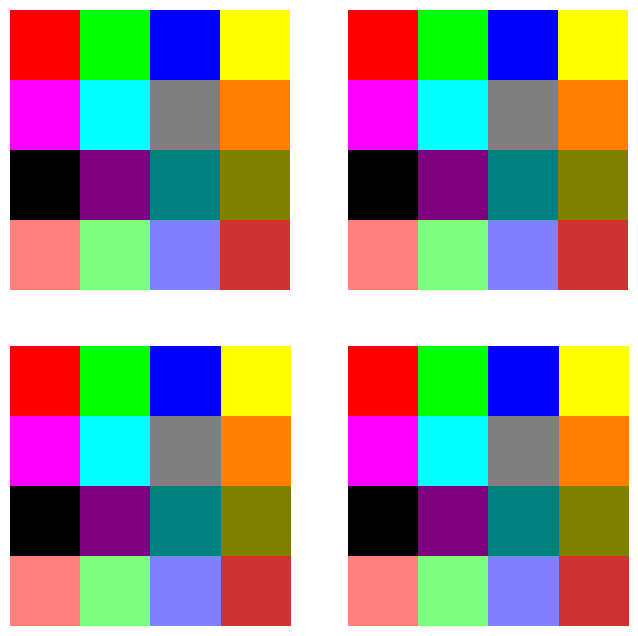

In [648]:
# "GRID Partition" test!
P = 2   # based on pseudo-code from paper, we should have 4 different grid 4x4 "grids" (sqrt(HW/G^2) = sqrt(64/4))

# reformat to image from (H,W,C) to shape PyTorch module will expect (C,H,W)
x = test_image.permute(2,0,1)
x = x.unsqueeze(0)
B, C, H, W = x.shape           # (1, 3, 8, 8)
P = 2

# partition into WINDOW (indep patches)
x = x.reshape(B, C, H//P, P, W//P, P)  # (B, C, H, W) -->  (B, C, H/P, P, W/P, P)

# confirm that induvid patches were made, by visualizing
# permute and reshape so we can view w/ plt, incl  "SWAPAXES(x, -2, -3)"
x = x.permute(0, 3, 5, 2, 4, 1) # (B, C, H/P, P, W/P, P) --> (B, P, P, H/P, W/P, C)
B, HdP, WdP, P, _, C = x.shape
x = x.reshape(B, HdP*WdP, P, P, C) #  (B, H/P, W/P, P, P, C) --> (HW/P**2, P, P, C)
x = x.squeeze(0)
print(x.shape)

fig, axs = plt.subplots(2, 2, figsize=(8, 8))  # Create a 4x4 grid of subplots for 16 patches
for i, ax in enumerate(axs.flatten()):
    # Extract each 2x2 patch and convert it to a NumPy array for visualization
    patch = x[i].numpy()  # Convert to (2, 2, 3) for RGB
    ax.imshow(patch)
    ax.axis('off')  # Hide the axis for each patch
    
plt.show()

## Construct Block Attention and Grid Attention
* Currently, both use RelPosTBlock as dictated by MaxViT, but can be swapped out with StdTBlock if needed

In [649]:
# Block Attention
class BlockAttention(nn.Module):
    def __init__(self, embd_size, head_size, block_size, patch_size, dropout, stoch_dep):
        super().__init__()
        assert (block_size[0] % patch_size == 0), f"H % patch_size == 0, but got H={block_size[0]} and patch_size={patch_size}"
        assert (block_size[1] % patch_size  == 0), f"W % patch_size == 0, but got W={block_size[1]} and patch_size={patch_size}"
        assert (embd_size >= head_size),      f"embd_size >= head_size, but got embd_size={embd_size} and head_size={head_size}"
        self.tblock = RelPosTBlock(embd_size, head_size, patch_size, patch_size, dropout)
        self.patch_size = patch_size
        self.stoch_dep = StochasticDepth(stoch_dep, "row")
        
    def forward(self, inp):  # (B,C,H,W) --> (B,C,H,W)
        B, C, H, W = inp.shape
        P = self.patch_size
        
        # partition into WINDOW (indep patches)
        x = inp.reshape(B, C, H//P, P, W//P, P)  # (B, C, H, W) -->  (B, C, H/P, P, W/P, P)
        x = x.permute(0, 2, 4, 3, 5, 1)          # (B, C, H/P, P, W/P, P) --> (B, H/P, W/P, P, P, C)
        x = x.reshape(B, (H*W)//(P**2), P**2, C) # (B, H/P, W/P, P, P, C) --> (B, HW/P^2, P^2, C)
        x = self.tblock(x)  # (B, HW/P^2, P^2, C) --> (B, HW/P^2, P^2, C)    # 2-dim batch space of B * HW/P^2

        # unpartition indep patches to original, do the reverse
        x = x.reshape(B, H//P, W//P, P, P, C) # (B, HW/P^2, P^2, C) --> (B, H/P, W/P, P, P, C)
        x = x.permute(0, 5, 1, 3, 2, 4)       # (B, H/P, W/P, P, P, C) --> (B, C, H/P, P, W/P, P)
        x = x.reshape(B, C, H, W)             # (B, C, H/P, P, W/P, P) --> (B, C, H, W)

        return inp + self.stoch_dep(x)   

In [652]:
# Grid Attention
class GridAttention(nn.Module):
    def __init__(self, embd_size, head_size, block_size, patch_size, dropout, stoch_dep):
        super().__init__()
        assert (block_size[0] % patch_size == 0), f"H % patch_size == 0, but got H={block_size[0]} and patch_size={patch_size}"
        assert (block_size[1] % patch_size  == 0), f"W % patch_size == 0, but got W={block_size[1]} and patch_size={patch_size}"
        assert (embd_size >= head_size),      f"embd_size >= head_size, but got embd_size={embd_size} and head_size={head_size}"
        # effective patch of H/P x W/P for Grid Attention (whereas twas P x P for Block Attention). 
        self.tblock = RelPosTBlock(embd_size, head_size, block_size[0]//patch_size, block_size[1]//patch_size, dropout)
        self.patch_size = patch_size
        self.stoch_dep = StochasticDepth(stoch_dep, "row")
        
    def forward(self, inp):  # (B,C,H,W) --> (B,C,H,W)
        B, C, H, W = inp.shape
        P = self.patch_size
        
        # partition into GRID (indep patches, but do swap-axes(-2,-3) in same permute)
        x = inp.reshape(B, C, H//P, P, W//P, P)  # (B, C, H, W) -->  (B, C, H/P, P, W/P, P)
        x = x.permute(0, 3, 5, 2, 4, 1)          # (B, C, H/P, P, W/P, P) --> (B, P, P, H/P, W/P, C)
        x = x.reshape(B, P**2, (H*W)//(P**2), C) # (B, P, P, H/P, W/P, C) --> (B, P^2, HW/P^2, C)
        x = self.tblock(x)  # (B, P^2, HW/P^2, C) --> (B, P^2, HW/P^2, C)    # 2-dim batch space of B * HW/P^2

        # unpartition indep patches to original, do the reverse
        x = x.reshape(B, P, P, H//P, W//P, C) # (B, P^2, HW/P^2, C) --> (B, P, P, H/P, W/P, C)
        x = x.permute(0, 5, 3, 1, 4, 2)       # (B, P, P, H/P, W/P, C) --> (B, C, H/P, P, W/P, P)
        x = x.reshape(B, C, H, W)             # (B, C, H/P, P, W/P, P) --> (B, C, H, W)

        return inp + self.stoch_dep(x)

## Construct MBConv
First, we construct **Squeeze-and-Excitation (SE) Block**:
1. Squeeze Step: reduce each channel to a single scalar (pool spatial dim)
2. Excitation Step: generate a set of "recalibrating" channel-wise weights
    * reduce the channel dimension, then re-expand dimension
3. Recallibration Step: multiply the original feature map by the channel-wise weights scaled between 0-1


Next, we construct **MBConv (Mobile Inverted Bottleneck Convolution) Block**: 
1. expands the number of channels (in_ch → mid_ch, see convblk_a)
2. applies a *depthwise* convolution (mid_ch → mid_ch, see convblk_b)
   * will downsample the spatial dimensions of the feature maps with stride=2 (every few layers), else stride=1
4. optionally, applies squeeze excitation to dynamically determine the importance of each of the expanded channels (mid_ch → mid_ch, see sq_ex)
5. reduce the number of channels (mid_ch → out_ch, see conv_c)
    * it is assumed that out_ch < mid_ch

In [653]:
class SEBlock(nn.Module):
    def __init__(self, in_ch, sqz_ch):
        super().__init__()
        self.squeeze = torch.nn.AdaptiveAvgPool2d(1)  # global 2D pooling
        self.excite = nn.Sequential(
            nn.Linear(in_ch, sqz_ch),
            nn.GELU(),
            nn.Linear(sqz_ch, in_ch)
        )
        self.recalibrate = nn.Sigmoid()

    def forward(self, inp):
        B,C,H,W = inp.shape
        x = self.squeeze(inp)    # (B,C,H,W) --> (B,C,1,1)

        x = x.view(B,C)          # (B,C,1,1) --> (B,C)
        x = self.excite(x)       # (B,C) --> (B,sqz_ch) --> (B,C)
        x = x.view(B,C,1,1)      # (B,C) --> (B,C,1,1)
        
        x = self.recalibrate(x)  # (B,C,1,1) --> (B,C,1,1)
        return inp * x           # (B,C,H,W)*(B,C,1,1) --> (B,C,H,W)

In [758]:
class MBConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch, stride, expand_scale, sqz_scale, stoch_dep):
        super().__init__()
        assert (expand_scale > 1.0), f"expand_scale > 1.0, but got expand_scale={expand_scale}"
        assert (sqz_scale < 1.0), f"sqz_scale < 1.0, but got sqz_scale={sqz_scale}"
        
        mid_ch = int(out_ch * expand_scale)
        sq_ch = int(out_ch * sqz_scale)

        self.stoch_drop = StochasticDepth(stoch_dep, "row")

        # MBConv Residual Block
        self.bn = nn.BatchNorm2d(in_ch)

        self.convblk_a = nn.Sequential( 
            nn.Conv2d(in_ch, mid_ch, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm2d(mid_ch),
            nn.GELU()
        )
        self.convblk_b = nn.Sequential(
            nn.Conv2d(mid_ch, mid_ch, kernel_size=3, stride=stride, padding=1, groups=mid_ch),  # Depthwise Conv2D
            nn.BatchNorm2d(mid_ch),
            nn.GELU()
        )
        self.sq_ex = SEBlock(mid_ch, sq_ch)
        self.conv_c = nn.Conv2d(mid_ch, out_ch, kernel_size=1)

        # Shortcut Path
        self.shortcut = nn.Sequential(   # separate spatial transform and channel transform, so less bias and better gradient retention
            # stride usually 1 or 2 (but others supported), account for changing spatial dim of skip connection if stride>1 
            nn.AvgPool2d(kernel_size=3, stride=stride, padding=1) if (stride != 1) else nn.Identity(),
            # account for changing channel dim of skip connection if in_ch != out_ch
            nn.Conv2d(in_ch, out_ch, kernel_size=1, stride=1, padding=0) if (in_ch != out_ch) else nn.Identity()
        )
        
    def forward(self, inp):  # (B,in_ch,H,W) --> (B,out_ch,ceil(H/stride),ceil(W/stride))
        # MBConv Residual Block
        x = self.bn(inp)
        x = self.convblk_a(x)   # (B,in_ch,H,W) --> (B,mid_ch,H,W)
        x = self.convblk_b(x)   # (B,mid_ch,H,W) --> (B,mid_ch,ceil(H/stride),ceil(W/stride))
        x = self.sq_ex(x)       # (B,mid_ch,ceil(H/stride),ceil(W/stride)) --> (B,mid_ch,ceil(H/stride),ceil(W/stride))
        x = self.conv_c(x)      # (B,mid_ch,ceil(H/stride),ceil(W/stride)) --> (B,out_ch,ceil(H/stride),ceil(W/stride)) 

        # Shortcut Path
        skip = self.shortcut(inp) # (B,in_ch,H,W) --> (B,out_ch,ceil(H/stride),ceil(W/stride))

        return skip + self.stoch_drop(x)
        

## Construct MaxViT Block and MaxViT Stage

In [759]:
class MaxViTBlock(nn.Module):
    def __init__(
        self, 
        block_size: Tuple[int, int],  # spatial dim of "image" being processed (H,W)
        patch_size: int,              # patch dim to partition "image" into patch_size x patch_size blocks (must cleanly divide H and W) 
        in_ch: int,                   # input channel dim for block
        out_ch: int,                  # output channel dim for block
        stride: int,                  # stride of MBConv (will be 1 or 2)
        expand_scale: float,          # scale by which MBConv expands channel dim (must be > 1.0)
        sqz_scale: float,             # scale by which MBConv shrinks channel dim for Squeeze Excitation (must be < 1.0)
        head_size: int,               # head embedding dim for Multi-Head Attention (Block and Grid) (must be < out_ch)
        dropout: float,               # dropout probability (must be in [0,1])
        stoch_dep: float              # stochastic depth probability (must be in [0,1], evaluated in "row" mode)
    ):
        super().__init__()
        self.mbconv = MBConvBlock(in_ch, out_ch, stride, expand_scale, sqz_scale, stoch_dep)
        # MBConvBlock modifies block_size tuple spatial dim, so update its value for battn and gattn 
        block_sz = (ceil(block_size[0]/stride), ceil(block_size[1]/stride))
        self.battn = BlockAttention(out_ch, head_size, block_sz, patch_size, dropout, stoch_dep)
        self.gattn = GridAttention(out_ch, head_size, block_sz, patch_size, dropout, stoch_dep)
        
    def forward(self, x):
        x = self.mbconv(x)  # (B,in_ch,H,W) --> (B,out_ch,ceil(H/stride),ceil(W/stride))
        x = self.battn(x)   # (B,C,H',W') --> (B,C,H',W')
        x = self.gattn(x)   # (B,C,H',W') --> (B,C,H',W')
        return x

In [825]:
class MaxVitStage(nn.Module):
    def __init__(
        self, 
        num_blocks: int,           # number of MaxViTBlock blocks used in the MaxVitStage   
        block_size,                # spatial dim of input "image" being processed (H,W)
        patch_size,                # patch dim to partition "image" into patch_size x patch_size for all Block/Grid Attention 
        in_ch,                     # input channel dim for stage
        out_ch,                    # output channel dim for stage
        spatial_downsamp_scale,    # scale by which to downsample block_size (ex. if =2, scales (H,W)-->(ceil(H/2),ceil(W/2))
        expand_scale,              # scale by which MBConv expands channel dim (must be > 1.0)
        sqz_scale,                 # scale by which MBConv shrinks channel dim for Squeeze Excitation (must be < 1.0)
        head_size,                 # head embedding dim for Multi-Head Attention (Block and Grid) (must be < out_ch)
        dropout,                   # dropout probability (must be in [0,1])
        stoch_dep                  # stochastic depth probability (must be in [0,1], evaluated in "row" mode)
    ):
        super().__init__()
        assert(ceil(block_size[0]/spatial_downsamp_scale)%patch_size==0), f"patch_size={patch_size} is not compatible with downsamp(H)={ceil(block_size[0]/spatial_downsamp_scale)}"
        assert(ceil(block_size[1]/spatial_downsamp_scale)%patch_size==0), f"patch_size={patch_size} is not compatible with downsamp(W)={ceil(block_size[1]/spatial_downsamp_scale)}"
        assert(isinstance(spatial_downsamp_scale, int) and spatial_downsamp_scale >= 1), f"expected spatial_downsamp_scale to be int >= 1, but got spatial_downsamp_scale={spatial_downsamp_scale}"
        
        blocks_list = []
        for i in range(num_blocks):
            # if we want to downsamp spatial dim, then it should only be done at first Block in the Stage
            b_stride = spatial_downsamp_scale if i==0 else 1
            b_block_size = block_size if i==0 else (ceil(block_size[0]/spatial_downsamp_scale), ceil(block_size[1]/spatial_downsamp_scale))
            # if in_ch != out_ch, we only change channel dim at the first Block in the Stage
            b_in_ch = in_ch if i==0 else out_ch
            
            blocks_list.append(
                MaxViTBlock(
                    block_size   = b_block_size,   # spatial dim of "image" being processed (H,W)
                    patch_size   = patch_size,     # patch dim to partition "image" into patch_size x patch_size blocks (must cleanly divide H and W) 
                    in_ch        = b_in_ch,        # input channel dim for block
                    out_ch       = out_ch,         # output channel dim for block
                    stride       = b_stride,       # stride of MBConv (will be 1 or 2)
                    expand_scale = expand_scale,   # scale by which MBConv expands channel dim (must be > 1.0)
                    sqz_scale    = sqz_scale,      # scale by which MBConv shrinks channel dim for Squeeze Excitation (must be < 1.0)
                    head_size    = head_size,      # head embedding dim for Multi-Head Attention (Block and Grid) (must be < out_ch)
                    dropout      = dropout,        # dropout probability (must be in [0,1])
                    stoch_dep    = stoch_dep       # stochastic depth probability (must be in [0,1], evaluated in "row" mode)
                )
            )
        self.blocks = nn.Sequential(*blocks_list)
        
    def forward(self, x):
        return self.blocks(x)

## Construct Stem Stage, Classification Stage, and MaxVit
<div>
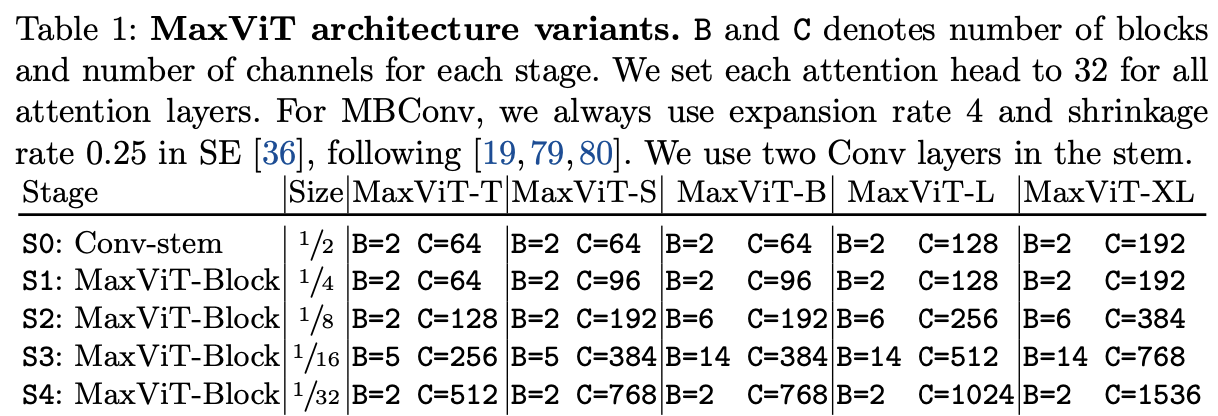
</div>

<div>
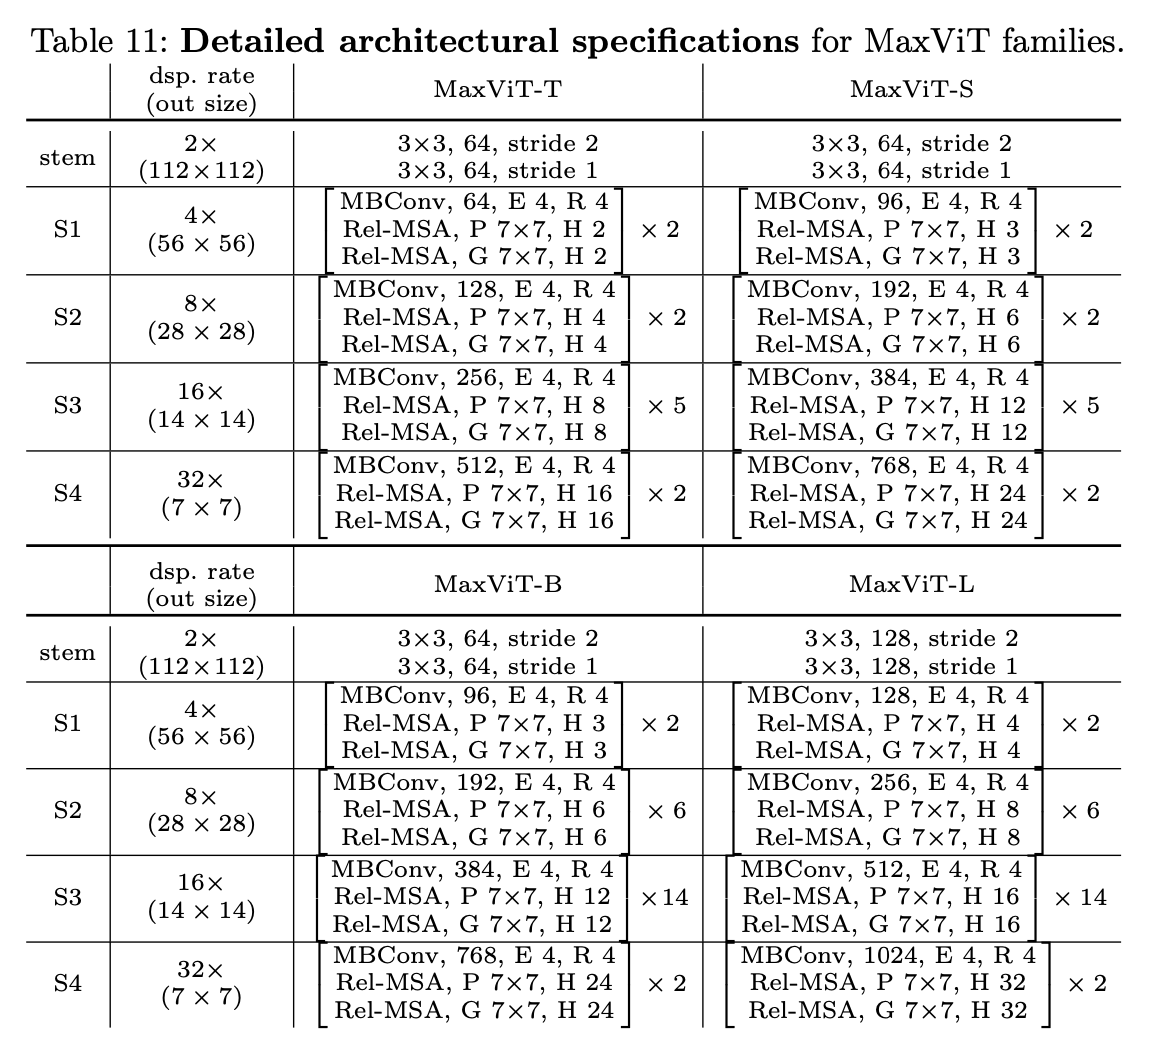
</div>


In [826]:
class ConvStemStage(nn.Module):
    def __init__(self, num_blocks, in_ch, out_ch, stride):
        super().__init__()
        blocks_list = []
        for i in range(num_blocks):
            # if in_ch != out_ch, we only change channel dim at the first Block in the Stage
            b_in_ch = in_ch if i==0 else out_ch
            b_stride = stride if i==0 else 1
            
            blocks_list.append(
                nn.Sequential(
                    nn.Conv2d(b_in_ch, out_ch, kernel_size=3, stride=b_stride, padding=1), 
                    nn.BatchNorm2d(out_ch),
                    nn.GELU()
                )
            )

        self.blocks = nn.Sequential(*blocks_list)

    def forward(self, x):
        return self.blocks(x)

In [904]:
class MaxViT(nn.Module):
    def __init__(
        self,
        inp_spatial_dim: Tuple[int, int],               # spatial dim of images being processed (H,W)
        inp_channel_dim: int,                           # channel dim of images being processed (1 for grayscale, 3 for RGB)
        blocks_in_stem_stage: int,                      # number of blocks in the single ConvStemStage
        channels_in_stem_stage: int,                    # output channel-dim of the single ConvStemStage
        blocks_per_maxvit_stage: List[int],             # number of MaxViTBlocks in each MaxViTStage
        channels_per_maxvit_stage: List[int],           # output channel-dim of each MaxViTStage
        patch_size_per_maxvit_stage: List[int],         # patch_size param to all MaxViTBlocks in each MaxViTStage
        spatial_downscale_per_maxvit_stage: List[int],  # spatial_downsamp_scale param to all MaxViTBlocks in each MaxViTStage
        expand_scale_per_maxvit_stage: List[int],       # expand_scale param to all MaxViTBlocks in each MaxViTStage
        sqz_scale_per_maxvit_stage: List[int],          # sqz_scale param to all MaxViTBlocks in each MaxViTStage
        head_size_per_maxvit_stage: List[int],          # head_size param to all MaxViTBlocks in each MaxViTStage
        dropout_per_maxvit_stage: List[int],            # dropout param to all MaxViTBlocks in each MaxViTStage
        stoch_dep_per_maxvit_stage: List[int],          # stoch_dep param to all MaxViTBlocks in each MaxViTStage
        num_classes: int,                               # number of classes to be classified        
    ):
        super().__init__()
        assert (inp_channel_dim==1 or inp_channel_dim==3), f"expected inp_channel_dim to be 1 or 3, but got inp_channel_dim={inp_channel_dim}"
        assert (len(blocks_per_maxvit_stage) == len(channels_per_maxvit_stage)), f"Please make sure all *_per_maxvit_stage params are list of same len"
        
        self.stem_stage = ConvStemStage(num_blocks=blocks_in_stem_stage, in_ch=inp_channel_dim, out_ch=channels_in_stem_stage, stride=2)
        
        maxvit_stage_dict = OrderedDict()
        for i in range(len(blocks_per_maxvit_stage)):
            # scale b_block_size to account for downscaling of spatial dim from prev stage
            if i == 0:   # scaled from self.stem_stage
                b_block_size = (ceil(inp_spatial_dim[0]/2), ceil(inp_spatial_dim[1]/2))   # scaled from self.stem_stage
            else:        # scaled from prev MaxViTStage
                b_block_size = (ceil(b_block_size[0]/spatial_downscale_per_maxvit_stage[i-1]), ceil(b_block_size[1]/spatial_downscale_per_maxvit_stage[i-1])) 
            # prev b_out_ch must be next b_in_ch
            b_in_ch = channels_in_stem_stage if i==0 else channels_per_maxvit_stage[i-1]
            b_out_ch = channels_per_maxvit_stage[i]
            
            maxvit_stage_dict[f"MaxViTStage{i}"] = MaxVitStage(
                num_blocks=blocks_per_maxvit_stage[i],                        # number of MaxViTBlock blocks used in the MaxVitStage   
                block_size=b_block_size,                                      # spatial dim of "image" being processed (H,W)
                patch_size=patch_size_per_maxvit_stage[i],                    # patch dim to partition "image" into patch_size x patch_size blocks (must cleanly divide H and W) 
                in_ch=b_in_ch,                                                # input channel dim for stage
                out_ch=b_out_ch,                                              # output channel dim for stage
                spatial_downsamp_scale=spatial_downscale_per_maxvit_stage[i], # scale by which to downsample block_size (ex. if =2, scales (H,W)-->(ceil(H/2),ceil(W/2))
                expand_scale=expand_scale_per_maxvit_stage[i],                # scale by which MBConv expands channel dim (must be > 1.0)
                sqz_scale=sqz_scale_per_maxvit_stage[i],                      # scale by which MBConv shrinks channel dim for Squeeze Excitation (must be < 1.0)
                head_size=head_size_per_maxvit_stage[i],                      # head embedding dim for Multi-Head Attention (Block and Grid)
                dropout=dropout_per_maxvit_stage[i],                          # dropout probability (must be in [0,1])
                stoch_dep=stoch_dep_per_maxvit_stage[i]                       # stochastic depth probability (must be in [0,1], evaluated in "row" mode)
            )
        self.maxvit_stages = nn.Sequential(maxvit_stage_dict)
        
        self.class_head = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),   # (B,C,H,W) --> (B,C,1,1)
            nn.Flatten(),              # (B,C,1,1) --> (B,C)
            nn.LayerNorm(channels_per_maxvit_stage[-1]),
            nn.Linear(channels_per_maxvit_stage[-1], channels_per_maxvit_stage[-1]),      # (B,C) --> (B,C)
            nn.GELU(),
            nn.Linear(channels_per_maxvit_stage[-1], channels_per_maxvit_stage[-1]//4),   # (B,C) --> (B,C//4)
            nn.GELU(),
            nn.Linear(channels_per_maxvit_stage[-1]//4, num_classes),                     # (B,C//4) --> (B,num_classes)
        )

        self._init_weights()

    def forward(self, x):
        x = self.stem_stage(x)          # (B,C,H,W) --> (B,channels_in_stem_stage,ceil(H/2),ceil(W/2))
        x = self.maxvit_stages(x)       # (B,C',H',W') --> (B,channels_per_maxvit_stage[-1],H'',W'') 
        x = self.class_head(x) # (B,C'',H'',W'') --> (B,num_classes)
        return x

    # as conventional, normalize layers to N(0, 0.2) 
    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.normal_(m.weight, mean=0.0, std=0.02)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0.0, std=0.02)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Embedding):
                torch.nn.init.normal_(m.weight, mean=0.0, std=0.02)


In [985]:
x = torch.randn(32, 1, 48, 48)  # sample batch size from dataloader

# self_stem:   (B,1,48,48)   --> (B,64,24,24)   
# maxvit_s0:   (B,64,24,24)  --> (B,64,24,24)     # spatial_down = 1, patch_size = 6
# maxvit_s1:   (B,64,24,24)  --> (B,128,12,12)    # spatial_down = 2, patch_size = 6
# maxvit_s2:   (B,128,12,12) --> (B,256,6,6)      # spatial_down = 2, patch_size = 3
# maxvit_s3:   (B,256,6,6)   --> (B,512,3,3)      # spatial_down = 2, patch_size = 3
# class_head:  (B,4608)      --> (B,7)

MaxViT_T = MaxViT(
    inp_spatial_dim=[48,48],                           # spatial dim of images being processed (H,W)
    inp_channel_dim=1,                                 # channel dim of images being processed (1 for grayscale, 3 for RGB)
    blocks_in_stem_stage=2,                            # number of blocks in the single ConvStemStage
    channels_in_stem_stage=64,                         # output channel-dim of the single ConvStemStage
    blocks_per_maxvit_stage=[2,2,5,2],                 # number of MaxViTBlocks in each MaxViTStage
    channels_per_maxvit_stage=[64,128,256,512],        # output channel-dim of each MaxViTStage
    patch_size_per_maxvit_stage=[6,6,3,3],             # patch_size param to all MaxViTBlocks in each MaxViTStage
    spatial_downscale_per_maxvit_stage=[1,2,2,2],      # spatial_downsamp_scale param to all MaxViTBlocks in each MaxViTStage
    expand_scale_per_maxvit_stage=[4,4,4,4],           # expand_scale param to all MaxViTBlocks in each MaxViTStage
    sqz_scale_per_maxvit_stage=[0.25,0.25,0.25,0.25],  # sqz_scale param to all MaxViTBlocks in each MaxViTStage
    head_size_per_maxvit_stage=[32,32,32,32],          # head_size param to all MaxViTBlocks in each MaxViTStage
    dropout_per_maxvit_stage=[0.1,0.1,0.2,0.2],        # dropout param to all MaxViTBlocks in each MaxViTStage
    stoch_dep_per_maxvit_stage=[0.0,0.05,0.1,0.15],    # stoch_dep param to all MaxViTBlocks in each MaxViTStage
    num_classes=7,                                     # number of classes to be classified        
)

out = MaxViT_T(x)
print(out.shape)
print(sum(p.numel() for p in MaxViT_T.parameters()), "total params")

torch.Size([32, 7])
30466095 total params


## Explore Data and Setup Training Pipeline

In [1003]:
workers = 4
batch_size = 32

# add some additional transforms during train time to prevent overfitting
train_transform = torchvision.transforms.Compose([
    transforms.Grayscale(num_output_channels=1),   # grayscale already, but reduce C from 3 to 1 
    transforms.RandomHorizontalFlip(p=0.5),        # Randomly mirror image 50% of the time (generalize faces)
    transforms.RandomRotation(degrees=10),         # Randomly tilt image by 10 degrees (generalize tilted faces / head)
    transforms.ColorJitter(brightness=0.1, contrast=0.1), # Randomly jitter brightness/contrast (generlize lighting conditions)
    transforms.RandomResizedCrop(size=(48, 48), scale=(0.9, 1.0), ratio=(0.9, 1.1)),  # Small variations in scale and aspect ratio
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # shift range from [0,1] --> [-1,1] (ie N(0,1))
])
test_transform = torchvision.transforms.Compose([
    transforms.Grayscale(num_output_channels=1),   # grayscale already, but reduce C from 3 to 1 
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # shift range from [0,1] --> [-1,1] (ie N(0,1))
])

train_dataset = torchvision.datasets.ImageFolder(root='../../Downloads/archive/train', transform=train_transform)
test_dataset = torchvision.datasets.ImageFolder(root='../../Downloads/archive/test', transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size, shuffle=True)

print(train_dataset)
print(test_dataset)

Dataset ImageFolder
    Number of datapoints: 28709
    Root location: ../../Downloads/archive/train
    StandardTransform
Transform: Compose(
               Grayscale(num_output_channels=1)
               RandomHorizontalFlip(p=0.5)
               RandomRotation(degrees=[-10.0, 10.0], interpolation=nearest, expand=False, fill=0)
               ColorJitter(brightness=(0.9, 1.1), contrast=(0.9, 1.1), saturation=None, hue=None)
               RandomResizedCrop(size=(48, 48), scale=(0.9, 1.0), ratio=(0.9, 1.1), interpolation=bilinear, antialias=True)
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )
Dataset ImageFolder
    Number of datapoints: 7178
    Root location: ../../Downloads/archive/test
    StandardTransform
Transform: Compose(
               Grayscale(num_output_channels=1)
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )


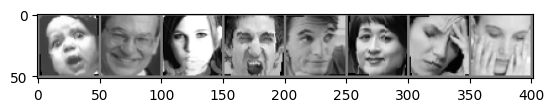

torch.Size([32, 1, 48, 48])
['fear', 'happy', 'neutral', 'angry', 'neutral', 'happy', 'sad', 'fear']


In [1004]:
def imshow(img):
    img = img / 2 + 0.5  # undo transforms.Normalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)), cmap='gray')
    plt.show()

# Get a batch of training data
dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images[:8]))

print(images.shape)

class_names = train_dataset.classes
targets = [class_names[i] for i in labels]
print(targets[:8])

In [1005]:
criterion = nn.CrossEntropyLoss()

loss = criterion(out, labels)  # out=(16,7), labels=(7)... from MaxViT_T dummy forward 
print(loss)

# confirm loss is average NLL of sum(softmax(logits))
prob = F.softmax(out, dim=-1)
loss_manual = prob[torch.arange(0, 32), labels].log().mean() * -1 
print(loss_manual)

tensor(1.9451, grad_fn=<NllLossBackward0>)
tensor(1.9451, grad_fn=<MulBackward0>)


#### Determine optimal learning rate for Adam Optimizer

In [1006]:
num_rates = 1000
log10_lrs = torch.linspace(-5, -0.5, num_rates)
lrs = 10**log10_lrs  # Create exp spaced of learning rates from 10e-5 to 0.3
losses = []

model = MaxViT(
    inp_spatial_dim=[48,48],                           # spatial dim of images being processed (H,W)
    inp_channel_dim=1,                                 # channel dim of images being processed (1 for grayscale, 3 for RGB)
    blocks_in_stem_stage=2,                            # number of blocks in the single ConvStemStage
    channels_in_stem_stage=64,                         # output channel-dim of the single ConvStemStage
    blocks_per_maxvit_stage=[2,2,5,2],                 # number of MaxViTBlocks in each MaxViTStage
    channels_per_maxvit_stage=[64,128,256,512],        # output channel-dim of each MaxViTStage
    patch_size_per_maxvit_stage=[6,6,3,3],             # patch_size param to all MaxViTBlocks in each MaxViTStage
    spatial_downscale_per_maxvit_stage=[1,2,2,2],      # spatial_downsamp_scale param to all MaxViTBlocks in each MaxViTStage
    expand_scale_per_maxvit_stage=[4,4,4,4],           # expand_scale param to all MaxViTBlocks in each MaxViTStage
    sqz_scale_per_maxvit_stage=[0.25,0.25,0.25,0.25],  # sqz_scale param to all MaxViTBlocks in each MaxViTStage
    head_size_per_maxvit_stage=[32,32,32,32],          # head_size param to all MaxViTBlocks in each MaxViTStage
    dropout_per_maxvit_stage=[0.1,0.1,0.2,0.2],        # dropout param to all MaxViTBlocks in each MaxViTStage
    stoch_dep_per_maxvit_stage=[0.0,0.05,0.1,0.15],    # stoch_dep param to all MaxViTBlocks in each MaxViTStage
    num_classes=len(class_names),                      # number of classes to be classified        
)


# for lr in lrs:
#     optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        
#     model.train()
    
#     for i, (inputs, targets) in enumerate(train_loader):
#         optimizer.zero_grad()
#         preds = model(inputs)
#         loss = criterion(preds, targets)
#         loss.backward()
#         optimizer.step()
#         break
#     losses.append(loss.item())

for lr in lrs:
    for param_group in optimizer.param_groups:  # go to next learning rate
        param_group['lr'] = lr.item()
        
    # Reset the model
    model.train()
    temp_loss = []
    for i, (inputs, targets) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        temp_loss.append(loss.item())
        
        if i >= 4:  # Only few iters per lr
            break

    losses.append(np.mean(np.array(temp_loss)))


In [1002]:
temp = np.log(np.array(losses))
x = [5,3,2]
np.mean(np.array(x))

np.float64(3.3333333333333335)

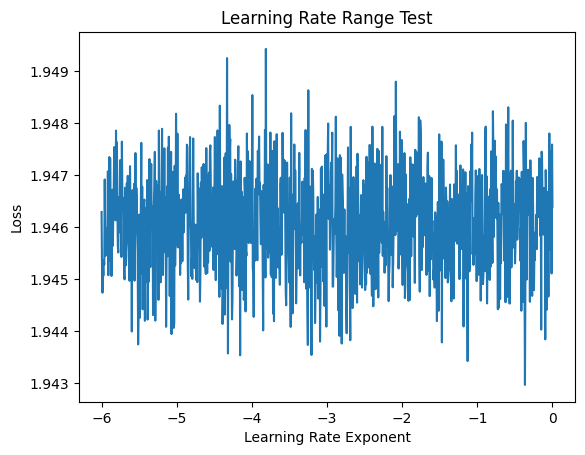

In [1036]:
# Plotting the results
temp = np.log(np.array(losses))

st = 0
end = 1000
plt.plot(torch.linspace(-6, 0, num_rates)[st:end], losses[st:end])
# plt.xscale('log')
plt.xlabel('Learning Rate Exponent')
plt.ylabel('Loss')
plt.title('Learning Rate Range Test')
plt.show()

In [997]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Accuracy on the test set: {accuracy:.2f}%')


True

In [1035]:
np.array(losses).min()

np.float64(1.9429707288742066)

In [1030]:
(torch.max(outputs, 1).indices == labels).sum() / labels.size(0)

tensor(0.2812)

In [352]:
import torchvision.models as models
models.maxvit_t()


MaxVit(
  (stem): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): GELU(approximate='none')
    )
    (1): Conv2dNormActivation(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
  )
  (blocks): ModuleList(
    (0): MaxVitBlock(
      (layers): ModuleList(
        (0): MaxVitLayer(
          (layers): Sequential(
            (MBconv): MBConv(
              (proj): Sequential(
                (0): AvgPool2d(kernel_size=3, stride=2, padding=1)
                (1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
              )
              (stochastic_depth): Identity()
              (layers): Sequential(
                (pre_norm): BatchNorm2d(64, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
                (conv_a): Conv2dNormActivation(
           